In [1]:
from jacobi import jacobi
import numpy as np
from matplotlib import pyplot as plt

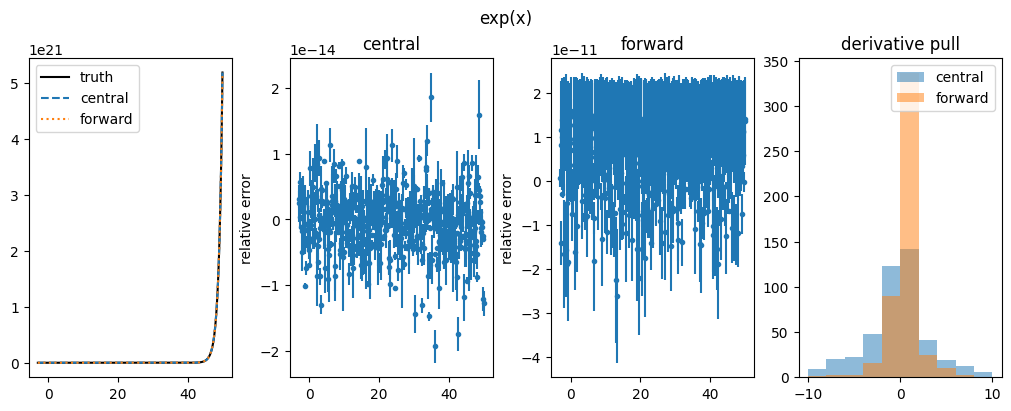

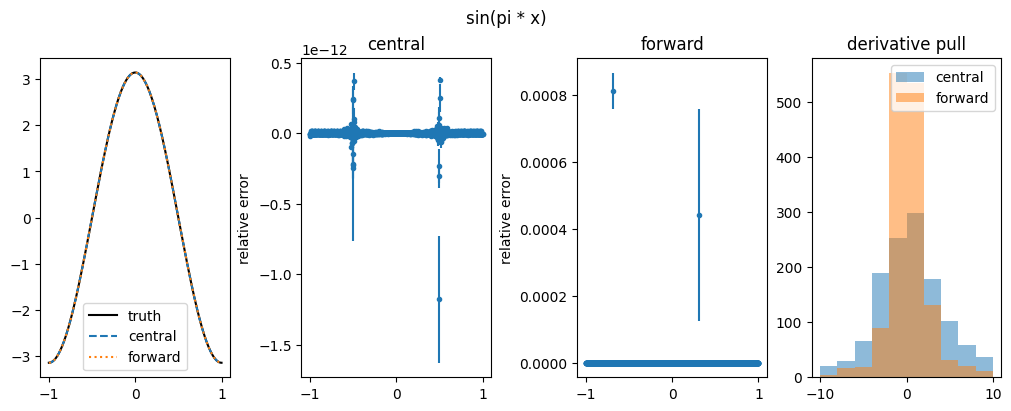

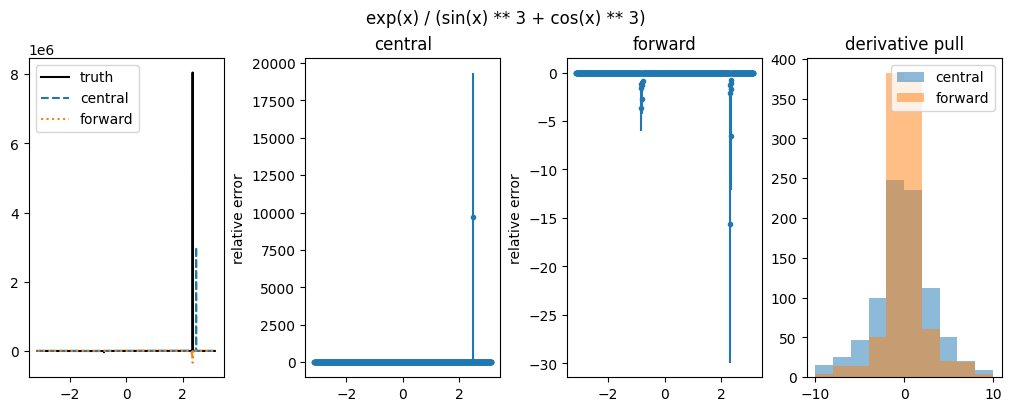

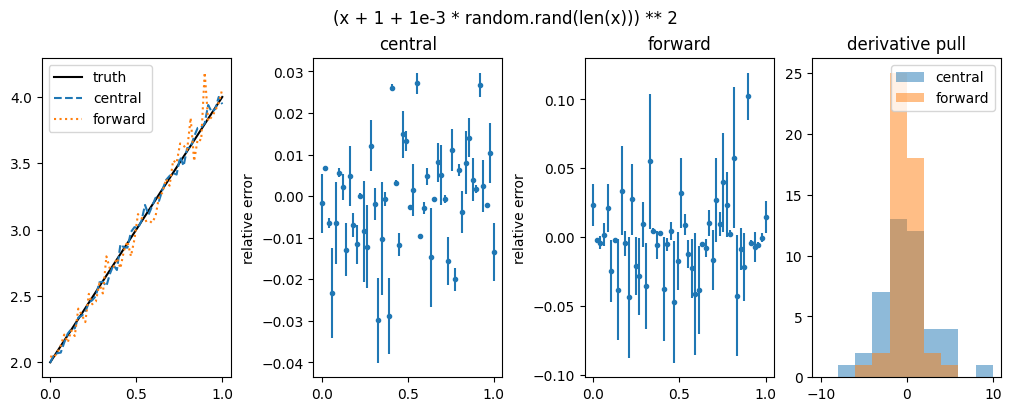

In [3]:
for x, fs, df in (
    (np.linspace(-3, 50, 500), "exp(x)", np.exp),
    (np.linspace(-1, 1, 1500), "sin(pi * x)", lambda x: np.pi * np.cos(np.pi * x)),
    (np.linspace(-1, 1, 1000) * np.pi, "exp(x) / (sin(x) ** 3 + cos(x) ** 3)", 
     lambda x: 0.5 * np.exp(x) * (3 * np.sin(x) + np.sin(3 * x) + 2 * np.cos(3 * x)) / (np.sin(x) ** 3 + np.cos(x) ** 3) ** 2),
    (np.linspace(0, 1), "(x + 1 + 1e-3 * random.rand(len(x))) ** 2", lambda x: 2 * (x + 1))
):
    f = eval("lambda x:" + fs, np.__dict__)
    y = f(x)
    dy0 = df(x)
    dy1, dy1e = jacobi(lambda p: f(p + x), 0, method=0)
    dy2, dy2e = jacobi(lambda p: f(p + x), 0, method=1)

    fig, ax = plt.subplots(1, 4, figsize=(10, 4), constrained_layout=True)
    fig.suptitle(fs)
    ax[0].plot(x, dy0, "-k", label="truth")
    ax[0].plot(x, dy1, "--C0", label="central")
    ax[0].plot(x, dy2, ":C1", label="forward")
    ax[0].legend()
    ax[1].set_title("central")
    ax[1].errorbar(x, dy1 / dy0 - 1, dy1e / np.abs(dy0), fmt=".")
    ax[1].set_ylabel("relative error")
    ax[2].set_title("forward")
    ax[2].errorbar(x, dy2/ dy0 - 1, dy2e / np.abs(dy0), fmt=".")
    ax[2].set_ylabel("relative error")
    ax[3].set_title("derivative pull")
    p = (dy1 - dy0) / dy1e
    ax[3].hist(p[~np.isnan(p)], alpha=0.5, range=(-10, 10), label="central")
    p = (dy2 - dy0) / dy2e
    ax[3].hist(p[~np.isnan(p)], alpha=0.5, range=(-10, 10), label="forward")
    ax[3].legend()
    if np.all(x > 0) and x[-1] / x[0] > 1e3:
        for axi in ax[:3]:
            axi.set_xscale("log")